## Introduction
- This notebook will apply the cleaned dataset from Homework1 and use it to create 3 different models to predict the number of covid-19 death cases in future years with repect to various parameters.CDC collects and makes public deidentified individual-case data on a daily basis, submitted using standardized case reporting forms. In this analysis, we focus on using the data collected by CDC to build a data analytics solution for death risk prediction.
    - The value “Death” = "Y" indicates that a person has been declared dead after catching covid virus . 
    - The value “Death” = "N" indicates that a person has been declared recovered after catching covid virus.
- Each model will be a supervised learning model and the output will be a binary classification. 
- For each applicant a number of features will be given and the target, Death yes/no (dependent variable), will be predicted.

This homework will be broken down into 4 main parts:
1. We will review the dataset from homework one and decide on which features to use to build our model
2. Creation of Linear Regression model and analyse
3. Creation of a Logistical Regression model and analyse
4. Creation of Random Forest model and analyse
5. We will then find the best of 3 and retrain that model based on given test data .csv

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier

# Allows plots to appear directly in the notebook.
%matplotlib inline

import matplotlib.patches as mpatches

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

# hide ipykernel warnings 
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

# (1) Data understanding :

The original dataset from CDC has been cleaned and is now imported as a starting point for this work. 
1. A summary of this plan can be seen in the table below;
2. In addition a number of extra features were added that were not in the original dataset.
    - cdc_case_earliest_days : Measures days in a year earlier of the date related to the Date Received by CDC.
    - cdc_report_days : An equivalent conversion of datefield information measured in days of a year.
    - age_category: Provides classification of age group 
- Here we will import cleaned dataset

In [2]:
# Read a CSV dataset with 10 example into a dataframe.

df = pd.read_csv('final_covid19_20201672_cdc.csv')
df.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,cdc_case_earliest_days,cdc_report_days,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,age_category
0,11/2/2020,11/5/2020,NaN,304,292,Probable Case,Male,Missing,"White, Non-Hispanic",No,Missing,No,Missing,Missing
1,12/1/2020,NaN,NaN,333,273,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,Missing,No,Missing,Young
2,10/29/2020,10/29/2020,NaN,300,285,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Missing,No,Missing,Adult
3,4/30/2020,5/13/2020,4/30/2020,118,116,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,No,No,Unknown,Old
4,4/16/2020,4/26/2020,4/17/2020,104,99,Laboratory-confirmed case,Female,80+ Years,"White, Non-Hispanic",Yes,Yes,Yes,Yes,Old
5,11/3/2020,11/3/2020,NaN,305,290,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Missing,No,Missing,Young
6,12/22/2020,NaN,NaN,354,273,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,Adult
7,11/30/2020,11/30/2020,NaN,332,317,Laboratory-confirmed case,Male,30 - 39 Years,"American Indian/Alaska Native, Non-Hispanic",Unknown,Missing,No,Missing,Adult
8,11/13/2020,11/19/2020,11/13/2020,315,306,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,Young
9,11/3/2020,11/12/2020,NaN,305,299,Probable Case,Female,50 - 59 Years,"White, Non-Hispanic",No,Missing,No,Missing,Adult


In [3]:
df.shape

(9545, 14)

In [4]:
df.dtypes

cdc_case_earliest_dt       object
cdc_report_dt              object
pos_spec_dt                object
cdc_case_earliest_days      int64
cdc_report_days             int64
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
age_category               object
dtype: object

In [5]:
df.isna().sum()

cdc_case_earliest_dt          0
cdc_report_dt              1954
pos_spec_dt                6755
cdc_case_earliest_days        0
cdc_report_days               0
current_status                0
sex                           0
age_group                     0
race_ethnicity_combined       0
hosp_yn                       0
icu_yn                        0
death_yn                      0
medcond_yn                    0
age_category                  0
dtype: int64

From this we can infere that there are no features having NA values in it except for cdc_report_dt and pos_spec_dt.

### Data Preparartion and features treatment
- The required loaded data set is evaluated and appropriate data types are set accordingly to all the features.
- continuos and categorical columns are listed and graphical visualizations are plotted down.
- Unwanted columns are dropped and few categories are normalized before training.
- convert identified objects as category features and label missing values as unknown.

In [6]:
# changes data type to category for below mentioned columns
for colmn in [e for e in df.columns if e not in ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt']]:
    df[colmn] = df[colmn].astype('category')

In [7]:
# setting data types for below mentioned columns accordingly
for colmn in ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt']:
    df[colmn] = df[colmn].astype('datetime64[ns]')
for integer in ['cdc_case_earliest_days', 'cdc_report_days']:
    df[integer] = df[integer].astype('int64')

#### Continuous columns are:

In [8]:
continuous_columns = df.select_dtypes(include=['int64']).columns.tolist()
continuous_columns

['cdc_case_earliest_days', 'cdc_report_days']

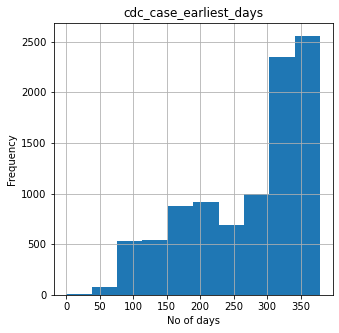

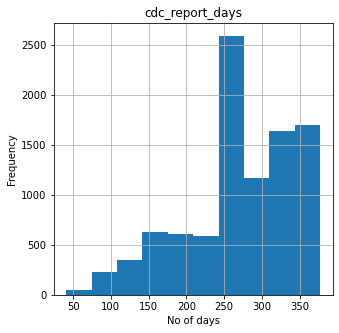

In [9]:
# plot histogram for all continous features
for colmn in continuous_columns:
        f = df[colmn].plot(kind='hist', figsize=(5,5))
        plt.title(colmn)
        plt.ylabel('Frequency')
        plt.xlabel('No of days')
        plt.grid()
        plt.show()

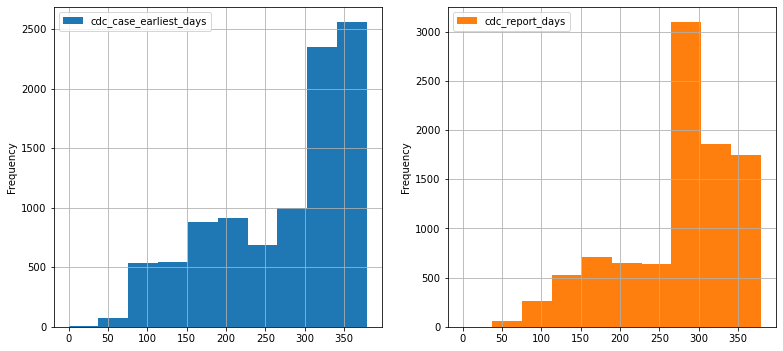

In [10]:
# Plot a histogram summary sheet of all the continuous features and save in a png file
df[continuous_columns].plot(kind='hist', subplots=True, figsize=(20,20), layout=(3,3), sharex=False, sharey=False, grid=True)
plt.savefig('Continuous_histograms_1-1.pdf')

In [11]:
df.loc[df.cdc_case_earliest_dt > df.cdc_report_dt, 'cdc_case_earliest_dt'] = df['cdc_report_dt']
df.loc[df.cdc_case_earliest_dt > df.pos_spec_dt, 'cdc_case_earliest_dt'] = df['pos_spec_dt']
df.loc[df.cdc_case_earliest_days > df.cdc_report_days, 'cdc_case_earliest_days'] = df['cdc_report_days']

In [12]:
# drop these features as they are calculated based on main feature and won't be usefull ahead.
del df['cdc_report_dt']
del df['pos_spec_dt']
del df['cdc_case_earliest_days']
del df['cdc_report_days']
del df['age_category']

##### Treat column "sex"

In [13]:
df.sex.value_counts(normalize=True)

Female     0.521111
Male       0.469041
Unknown    0.007753
Missing    0.001991
Other      0.000105
Name: sex, dtype: float64

In [14]:
indices = df[(df['sex'] == 'Unknown') | (df['sex'] == 'Missing')].index.tolist()
df.drop(indices, inplace=True)
df['sex'] = df['sex'].astype(str).astype('category')

##### Treat column "Age group"

In [15]:
df.age_group.value_counts()

20 - 29 Years    1743
30 - 39 Years    1549
40 - 49 Years    1391
50 - 59 Years    1326
60 - 69 Years    1027
10 - 19 Years     983
70 - 79 Years     543
80+ Years         445
0 - 9 Years       433
Missing            12
Name: age_group, dtype: int64

In [16]:
indices = df[df['age_group'] == 'Missing'].index.tolist()
df.drop(indices, inplace=True)

df['age_group'] = df['age_group'].astype(str).astype('category')

##### Treat column "race ethnicity"

In [17]:
df.race_ethnicity_combined.value_counts()

Unknown                                                 3541
White, Non-Hispanic                                     3272
Hispanic/Latino                                          960
Black, Non-Hispanic                                      706
Multiple/Other, Non-Hispanic                             522
Asian, Non-Hispanic                                      254
Missing                                                   92
American Indian/Alaska Native, Non-Hispanic               66
Native Hawaiian/Other Pacific Islander, Non-Hispanic      27
Name: race_ethnicity_combined, dtype: int64

In [18]:
df.loc[df.race_ethnicity_combined == 'Missing', 'race_ethnicity_combined'] = 'Unknown'
df['race_ethnicity_combined'] = df['race_ethnicity_combined'].astype(str).astype('category')

##### treat column "hosp_yn"

In [19]:
df.hosp_yn.value_counts(normalize=True)

No         0.539407
Missing    0.218962
Unknown    0.171610
Yes        0.069915
OTH        0.000106
Name: hosp_yn, dtype: float64

In [20]:
df = df[df.hosp_yn != 'OTH']
df.loc[df.hosp_yn == 'Missing', 'hosp_yn'] = 'Unknown'
df['hosp_yn'] = df['hosp_yn'].astype(str).astype('category')

##### treat column "icu_yn"

In [21]:
df.icu_yn.value_counts(normalize=True)

Missing    0.752622
Unknown    0.136879
No         0.101706
Yes        0.008793
Name: icu_yn, dtype: float64

In [22]:
df.loc[df.icu_yn == 'Yes', 'hosp_yn'] = 'Yes'
df.loc[df.icu_yn == 'Missing', 'icu_yn'] = 'Unknown'
df['icu_yn'] = df['icu_yn'].astype(str).astype('category')

##### treat column "medcond_yn"

In [23]:
df.medcond_yn.value_counts(normalize=True)

Missing    0.733552
No         0.092171
Yes        0.090264
Unknown    0.084013
Name: medcond_yn, dtype: float64

In [24]:
df.loc[df.medcond_yn == 'Missing', 'medcond_yn'] = 'Unknown'
df['medcond_yn'] = df['medcond_yn'].astype(str).astype('category')

#### Categorical columns are:

In [25]:
categorical_columns = df.select_dtypes(include=['category']).columns.tolist()
categorical_columns

['current_status',
 'sex',
 'age_group',
 'race_ethnicity_combined',
 'hosp_yn',
 'icu_yn',
 'death_yn',
 'medcond_yn']

#### Total features are:

In [26]:
features = continuous_columns + categorical_columns
features

['cdc_case_earliest_days',
 'cdc_report_days',
 'current_status',
 'sex',
 'age_group',
 'race_ethnicity_combined',
 'hosp_yn',
 'icu_yn',
 'death_yn',
 'medcond_yn']


current_status
Index 	 Count
Laboratory-confirmed case 	 8828
Probable Case 	 611

sex
Index 	 Count
Male 	 4473
Female 	 4965
Other 	 1

age_group
Index 	 Count
20 - 29 Years 	 1743
40 - 49 Years 	 1391
70 - 79 Years 	 543
80+ Years 	 444
30 - 39 Years 	 1549
50 - 59 Years 	 1326
10 - 19 Years 	 983
60 - 69 Years 	 1027
0 - 9 Years 	 433

race_ethnicity_combined
Index 	 Count
Unknown 	 3632
White, Non-Hispanic 	 3272
American Indian/Alaska Native, Non-Hispanic 	 66
Hispanic/Latino 	 960
Black, Non-Hispanic 	 706
Multiple/Other, Non-Hispanic 	 522
Asian, Non-Hispanic 	 254
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 27

hosp_yn
Index 	 Count
No 	 5090
Yes 	 662
Unknown 	 3687

icu_yn
Index 	 Count
Unknown 	 8396
No 	 960
Yes 	 83

death_yn
Index 	 Count

medcond_yn
Index 	 Count
Unknown 	 7717
Yes 	 852
No 	 870


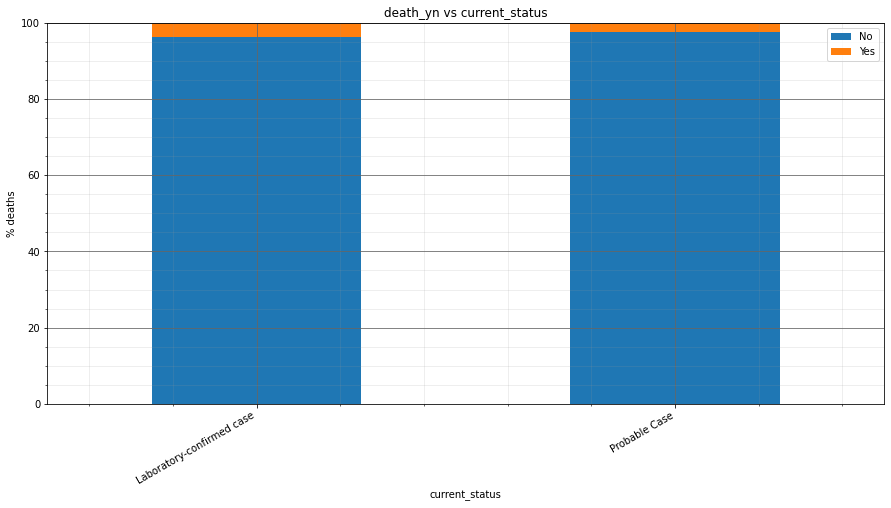

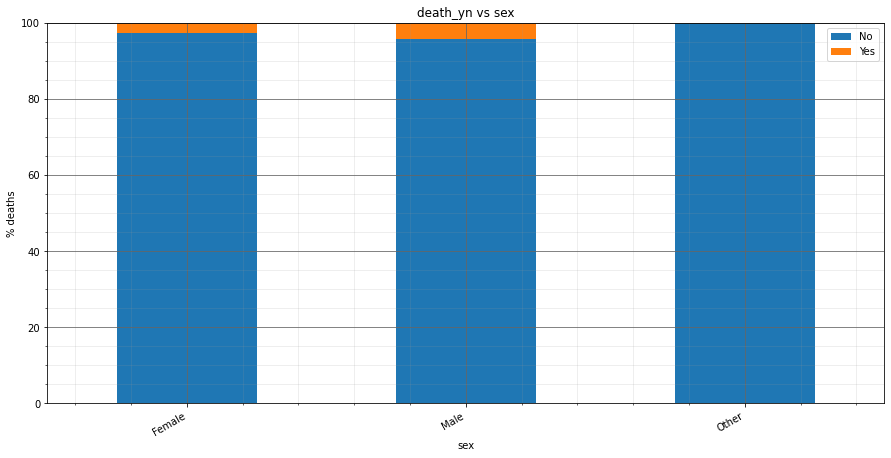

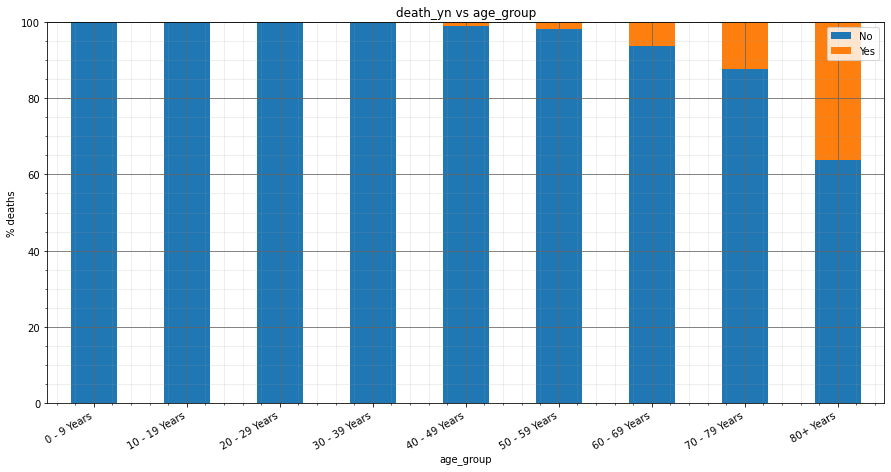

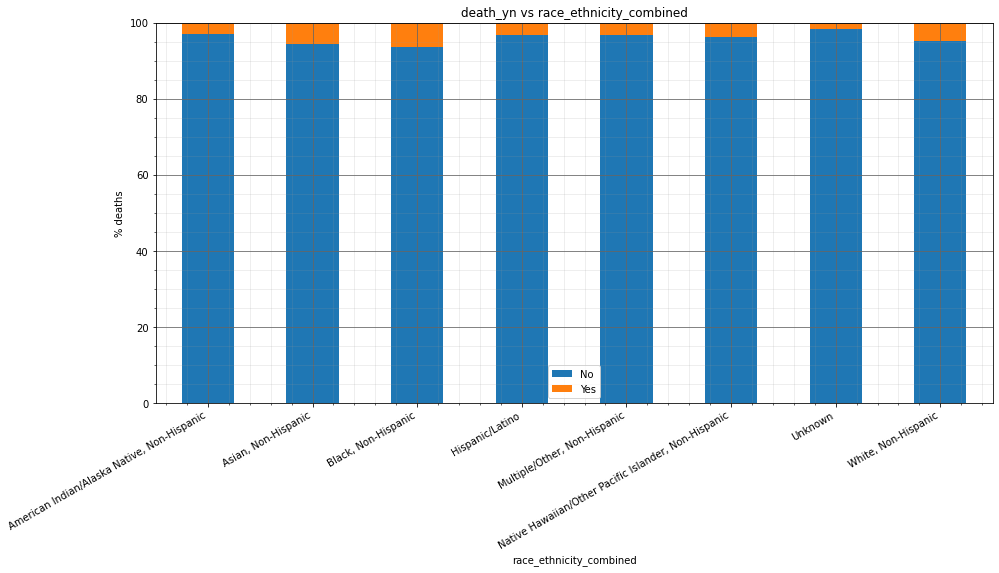

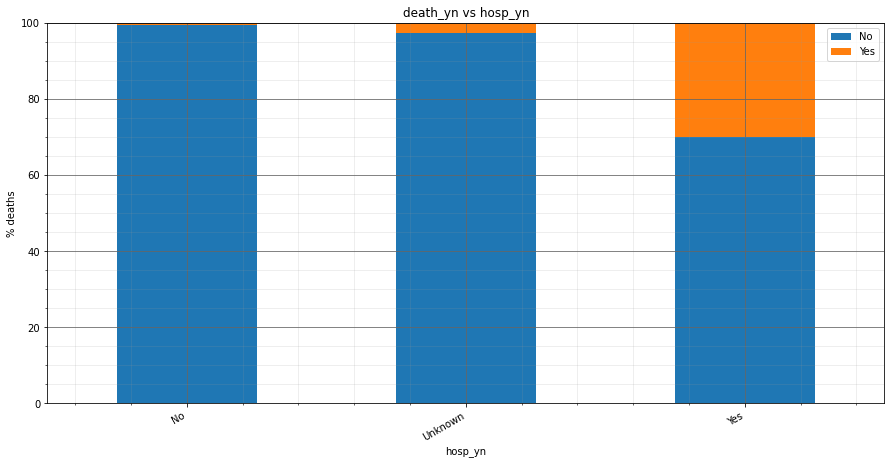

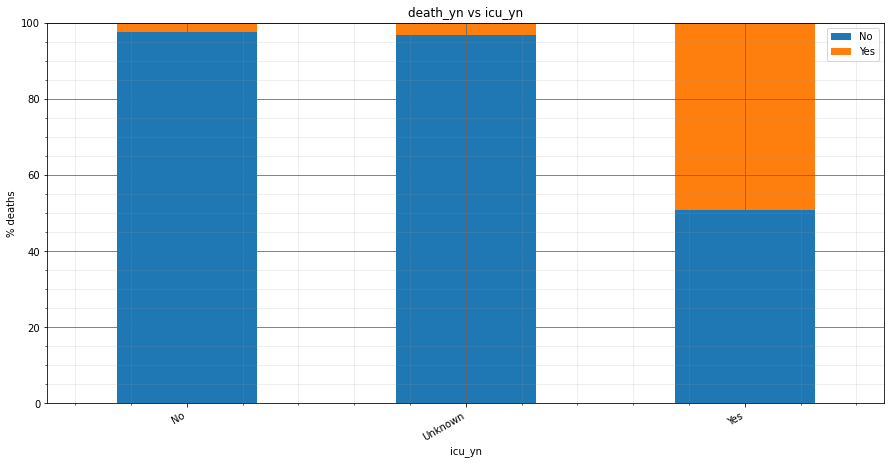

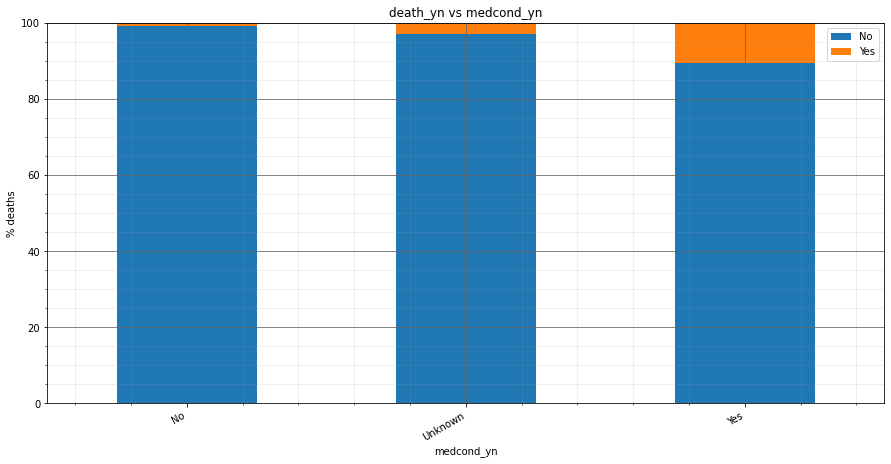

In [27]:

# to loop through all the features in categorical columns 
for second_feature in categorical_columns:
    details_of_feature = pd.unique(df[second_feature].ravel())

    # add new column and set values to zero
    df['percent'] = 0

    #print header
    print("\n" + '\033[1m' +second_feature+ '\033[0m')
    print("Index \t Count")
    
#  to avoid plotting between death_yn vs death_yn
    if('death_yn' != second_feature):
            

        # for each delinquency category
        for i in details_of_feature:

            count = df[df[second_feature] == i].count()['death_yn']
            count_percentage = (1 / count) * 100

            # print out index vs count
            print(i, "\t", count)

            index_list = df[df[second_feature] == i].index.tolist()
            for ind in index_list:
                df.loc[ind, 'percent'] = count_percentage

        group = df[['percent',second_feature,'death_yn']].groupby([second_feature,'death_yn']).sum()

        my_plot = group.unstack().plot(kind='bar', stacked=True, title="death_yn vs "+second_feature, figsize=(15,7), grid=True)

        # add legend     
        my_plot.legend(["No","Yes"])
        
        # add gridlines
        plt.grid(b=True, which='major', color='#666666', linestyle='-')
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        plt.xticks(rotation=30, ha='right')
        
        my_plot.set_xlabel(second_feature)
        my_plot.set_ylabel("% deaths")
        my_plot.set_ylim([0,100])
       
    else:
        continue

- in **age_group** feature feature we can observe that the old age people i.e. above 40 years are died due to this COVID-19 in a incresing fashion. This means that 80+ years category people is having more number of deaths and the number of deaths decreasing as age decreases.

- in **icu_yn** feature, shows that there are more number of deaths among the people who joined in ICU. While there are people who joined in ICU and able to recover(i.e. Not died) are quite less. 

- in **medcond_yn** feature, indicates that the people with presence of disease and died are less likely when compared to the people who are having disease(Yes) and not prone to death(death = No).

- in **sex** feature, there is almost equal number of people in male, female categories are dead with slight variation. But this feature does not provide indicate any trend to the target feature.

- while the **other features** does not indicate any strong trend between the target feature as the number of deaths are available in each sub-category of that feature

In [28]:
# Save this dataframe to .csv file
df.to_csv('cleaned_dataset.csv')

In [29]:
df.head(5)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,percent
1,2020-12-01,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,Unknown,No,Unknown,0.012958
2,2020-10-29,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,No,Unknown,0.012958
3,2020-04-30,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,No,No,Unknown,0.012958
4,2020-04-16,Laboratory-confirmed case,Female,80+ Years,"White, Non-Hispanic",Yes,Yes,Yes,Yes,0.117371
5,2020-11-03,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Unknown,No,Unknown,0.012958


### (1.1)  Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"


- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [30]:
# randomly sets and indexes column name for a nested sort operation.
df.set_index(np.random.permutation(df.index))
df.sort_index(inplace=True)

In [31]:
# Split the dataset into two datasets: 70% training and 30% test
X = pd.get_dummies(df.drop(columns=['death_yn', 'cdc_case_earliest_dt']), drop_first=True)
y = pd.get_dummies(df["death_yn"], prefix='death', drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3512, stratify=y)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9439
training range (70%):	 rows 0 to 6607
test range (30%): 	 rows 6607 to 9439


In [32]:
X_train.dtypes

percent                                                                         float64
current_status_Probable Case                                                      uint8
sex_Male                                                                          uint8
sex_Other                                                                         uint8
age_group_10 - 19 Years                                                           uint8
age_group_20 - 29 Years                                                           uint8
age_group_30 - 39 Years                                                           uint8
age_group_40 - 49 Years                                                           uint8
age_group_50 - 59 Years                                                           uint8
age_group_60 - 69 Years                                                           uint8
age_group_70 - 79 Years                                                           uint8
age_group_80+ Years             

In [33]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [34]:
X_train

,percent,current_status_Probable Case,sex_Male,sex_Other,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,...,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,0.012958,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0.012958,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0
2,0.012958,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0.117371,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.012958,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,0.012958,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,1,0
6603,0.012958,0,1,0,0,0,1,0,0,0,...,0,0,0,1,1,0,1,0,1,0
6604,0.012958,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6605,0.012958,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0


In [35]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
     percent  current_status_Probable Case  sex_Male  sex_Other  \
0  0.012958                             0         0          0   
1  0.012958                             0         0          0   
2  0.012958                             1         0          0   
3  0.117371                             1         0          0   
4  0.012958                             0         1          0   

   age_group_10 - 19 Years  age_group_20 - 29 Years  age_group_30 - 39 Years  \
0                        0                        0                        0   
1                        0                        1                        0   
2                        0                        1                        0   
3                        0                        0                        1   
4                        1                        0                        0   

   age_group_40 - 49 Years  age_group_50 - 59 Years  age_group_60 - 69 Years  \
0            

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [36]:
X_train.head(5)

,percent,current_status_Probable Case,sex_Male,sex_Other,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,...,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,0.012958,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0.012958,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0
2,0.012958,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0.117371,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.012958,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0


We will now reset the index of all training and test dataframes

In [37]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,percent,current_status_Probable Case,sex_Male,sex_Other,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,...,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic",race_ethnicity_combined_Unknown,"race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,0.012958,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0.012958,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0
2,0.012958,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0.117371,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.012958,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0


## (2) Linear Regression Model
<img src="linear_reg.png" height="300" width="300"> <br>
#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above



In [38]:
# Train/fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model

In [39]:
# Print the estimated linear regression coefficients.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['percent', 'current_status_Probable Case', 'sex_Male', 'sex_Other',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_Unknown',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Unknown',
       'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes', 'medcond_yn_Unknown',
       'medcond_yn_Yes'],
      dtype='object')

Coeficients are: 
 [[ 1.03308222e-03  5.80479671e-03  1.49818315e-02 -4.85722573e-17
  -8.88174750e-04 -8.57554698e-04 -

####  Interpreting the linear regression model

- Linear regression models are the most basic types of statistical techniques and widely used predictive analysis. They show a relationship between two variables with a linear algorithm and equation.
    - There is only one independent variable X which changes result on different values for Y.
    - This model is used to evaluate trends and make forecasts.
- The linear regression formula takes the following form:
    - $ 𝑡𝑎𝑟𝑔𝑒𝑡_𝑓𝑒𝑎𝑡𝑢𝑟𝑒=𝑤0+𝑤1∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒1+𝑤2∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒2+...+𝑤𝑛∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑛 $
    - The output of this formula will be a continuous value that can be less than 0 and higher than 1
- We can see the calculated intercept is -0.04 (w_0)
    - This is the starting point. i.e. if all other coefficients are zero then the model result will be -0.04
    - intercept is used to adjust the model's precision of predicting.
- We can see all the coefficients for each feature
    - For every one-unit increase in x, the y increases by ceff when all other variables are held constant.
    - The sum of all the feature*coefficients + intercept will result in the model prediction  
    
- Linear regression doesn't show suitable effects to resolve this problem case statement. An additional thresholding step is necessary to convert the output into a binary classification
- We will threshold the output so that any values >=0.5 will be cast to 1, any values <0.5 will be cast to 0


#### 2.3 Print the predicted target feature value for the first 10 training examples
- Here we will print the predicted target feature value for the first 10 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
 

In [40]:
# calculate the prediction and threshold the value. If >= 0.5 its true
# Predicted scores for each example. 
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_Yes  Predicted
0          0        0.0
1          0        0.0
2          0        0.0
3          0        0.0
4          0        0.0
5          0        0.0
6          0        0.0
7          0        0.0
8          0        0.0
9          0        0.0


#### Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [41]:
# Some more evaluation metrics.
print("********************Results based on train data *****************")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("------------------------------------------------------------------")

********************Results based on train data *****************
Accuracy:  0.9670046919933404
Confusion matrix: 
 [[6369    6]
 [ 212   20]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6375
           1       0.77      0.09      0.16       232

    accuracy                           0.97      6607
   macro avg       0.87      0.54      0.57      6607
weighted avg       0.96      0.97      0.95      6607

------------------------------------------------------------------


##### Findings for training data set
- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of 96%
    - Denoted by Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Confusion Matrix
    - A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, further explained are the matrix scenarios to be considered.
    - [0][0] True negative - The number that is predicted 0 that was actually 0
    - [0][1] false positive - The number that is predicted 1 that is actually 0
    - [1][0] false negative - The number that is predicted 0 that is actually 1
    - [1][1] True positive - The number that is predicted 1 that is actually 1
- Precision 
    - Precision is the measure of how many observations our model correctly predicted over the amount of correct and incorrect predictions
    - Given by Precision = TP / (TP + FP)
    - Precision Positive is 0.97
    - Precision Negative is 0.77
- Recall
    - Recall is the measure of how many observations our model correctly predicted over the total amount of observations
    - Recall = TP / (TP + FN)
    - Recall Positive is 1.00
    - Recall Negative is 0.09
- F1 Score
    - Is an a weighted average of Precision and recall
    - given by F1 Score = 2 * ( (Precision * Recall) / (Precision + Recall) )
    - F1 Score Positive is 0.98
    - F1 Score Negative is 0.16 

Summary
- The values for accuracy and precision seems pretty good.
- Due to the scarcity in negative features values the recall and F1 score seems to have dropped quite low.
- It is observed and tested that the data set has around 90% positive entries in its majority class.
- This possibly shows overfitting of the model due to unbalanced data set for target feature.
 

#### 2.4 Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set.
- Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). 


Printing Actual RiskPerformance vs predicted based on test data

In [42]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_Yes  Predicted
0           0        0.0
1           0        0.0
2           1        0.0
3           0        0.0
4           0        0.0
..        ...        ...
95          0        0.0
96          0        0.0
97          0        0.0
98          0        0.0
99          0        0.0

[100 rows x 2 columns]


##### Evaluation metrics based on test data

In [43]:
# Some more evaluation metrics.
print("********************* Results based on test Data ************************")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("******************** Results based on train Data **********************")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: \n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

********************* Results based on test Data ************************
Accuracy:  0.9668079096045198
Confusion matrix: 
 [[2727    5]
 [  89   11]]
Classification report
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2732
           1       0.69      0.11      0.19       100

    accuracy                           0.97      2832
   macro avg       0.83      0.55      0.59      2832
weighted avg       0.96      0.97      0.96      2832

******************** Results based on train Data **********************
Accuracy:  0.9670046919933404
Confusion matrix: 
 [[6369    6]
 [ 212   20]]

Classification report: 
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6375
           1       0.77      0.09      0.16       232

    accuracy                           0.97      6607
   macro avg       0.87      0.54      0.57      6607
weighted avg       0.96      0.97      0.95      6

**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test and train data appears to the same. 
- Precision
    - The precision score for predicting the positive case has reduced from 77% to 69%.
    - The precision score for predicting the negative case is same that is 97%.
- Recall
    - The recall score for predicting the positive case has increased from 9% to 11%.
    - The recall score for predicting the negative case is same that is 100%.
- F1
    - The f1 score for predicting the positive case has increased from 16% to 19%.
    - The f1 score for predicting the negative case has same that is 100%.

- The values for accuracy and recall for negative cases are more than expected.
- Seems like model is oversampled, need to verify and evaluate more further based on computations.
-  It is recommended that we always evaluate our model on a second data sample that was not used during training .This way we avoid overfitting or memorising the training data.

#### 2.4 Classic k-fold cross-validation
- We will now perform cross validation on the linear regression model. 
- Cross-validation is a statistical method used to estimate the performance (or accuracy) of machine learning models.  classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split.
- Cross-validation is a procedure that is used to avoid overfitting and estimate the skill of the model on new data.
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- Cross validation Function can be seen below

In [44]:
def LinReg_CV(X, y, cv=3, scoring='accuracy'):
    
    # store results in an array
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate LinearRegression model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # set threshold to >= 0.5
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score for all parameters
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.
- Function to perform cross validation and store results in dataframe. Cross validation looks at accuracy, precision, recall, f1. Returns a dataframe with results

In [45]:
def LinReg_CrossVal(X,y):

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = LinReg_CV(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using LinReg_CrossVal function
- Results summarised below

In [46]:
linRegDF = LinReg_CrossVal(X,y)
print(f"Taken result as mean for 10 cross validation :")
linRegDF

Taken result as mean for 10 cross validation :


,Linear_Regression
accuracy,0.965466
precision,0.765525
recall,0.104001
f1,0.176126


These results are marginally lower than previous results but this is expected. We have taken the mean of 10 sets of results. 

In [47]:
# Print the weights learned for each feature
cols = (X_train.columns.tolist())
coeffs = (multiple_linreg.coef_.ravel())

print(pd.DataFrame(data = {'coeffs': coeffs}, index=cols).sort_values(by='coeffs', ascending=True))

print("\nIntercept is: \n", multiple_linreg.intercept_)

                                                          coeffs
race_ethnicity_combined_Unknown                    -1.076143e-02
medcond_yn_Unknown                                 -9.525579e-03
age_group_30 - 39 Years                            -3.513410e-03
race_ethnicity_combined_Multiple/Other, Non-His... -2.889946e-03
age_group_40 - 49 Years                            -2.516837e-03
age_group_10 - 19 Years                            -8.881748e-04
age_group_20 - 29 Years                            -8.575547e-04
sex_Other                                          -4.857226e-17
percent                                             1.033082e-03
age_group_50 - 59 Years                             4.325657e-03
race_ethnicity_combined_White, Non-Hispanic         5.300282e-03
current_status_Probable Case                        5.804797e-03
race_ethnicity_combined_Asian, Non-Hispanic         1.072759e-02
race_ethnicity_combined_Native Hawaiian/Other P...  1.462216e-02
sex_Male                 

This shows that features like percent,age_group_20 contribute negligible in the training set. but age_group80+ and med_yn has large impact over the coefficients and intercept.

## (3) Logistic Regression   
<img src="logistic_reg.png" height="300" width="500"> <br>

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above

In [48]:
# Train/fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

In [49]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['percent', 'current_status_Probable Case', 'sex_Male', 'sex_Other',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_Unknown',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Unknown',
       'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes', 'medcond_yn_Unknown',
       'medcond_yn_Yes'],
      dtype='object')

Coeficients are: 
 [-0.01895802  0.12277848  0.5541967   0.         -1.44784104 -1.47349409
 -1.41163382 -0.46833377  0.

####  Inference from the results achieved.

Similar to linear regresison, training a logistic regression model means estimating a set of weights (one weight per feature, plus an extra weight called the bias or the intercept) on a dataset called the training set. 
- The output of the logistic function is a probability, a value between 0 and 1
- In classification the aim is to classify an example into one of two classes (target feature is 0 or 1). If we have several classes, we use a one-vs-all approach, by creating one dataset for each class.

- Differences aside there is a direct relationship between the two
    - The first part of logistic regression function is similar to linear regression i.e. We find the line of best fit
    - We then pass this equation through what is called a sigmoid function
    - This sigmoid function will output a value bound between 0 and 1. It is a probability
    - The model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0
    - All of these steps are carried out within the logistic regression function, however the threshold value can be adjusted up or down depending on the problem you are trying to solve.

The model estimated in logistic regression assumes the probability of class membership is given by the logistic function:  𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦(𝑡𝑎𝑟𝑔𝑒𝑡=1|𝑑𝑒𝑠𝑐𝑟𝑖𝑝𝑡𝑖𝑣𝑒_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠)=𝑙𝑜𝑔𝑖𝑠𝑡𝑖𝑐(𝑤0+𝑤1∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒1+𝑤2∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒2+...+𝑤𝑛∗𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑛)  where  𝑙𝑜𝑔𝑖𝑠𝑡𝑖𝑐(𝑥)  is defined as:  𝑙𝑜𝑔𝑖𝑠𝑡𝑖𝑐(𝑥)=𝑒𝑥1+𝑒𝑥=11+𝑒−𝑥
    
- P( y = 1 | X ) = p
- This probability, ranging from 0 to 1, can be used as a criterion to classify the new observation. The higher the value of p, the more likely the new observation belongs to class y = 1, instead of y = 0.
    - For example, we can choose a cutoff threshold of 0.5. When p > 0.5, the new observation will be classified as y = 1 , otherwise as y = 0.
- The learned logistic regresison model (e.g., set of weights  𝑤0,𝑤1,...,𝑤𝑛 ) can be used to predict the probability of the target feature for new examples where we know the descriptive features, but not the target feature.


#### 3.3 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples based on training data

In [50]:
# calculate the prediction and threshold the value. 
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death_Yes  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0


#### Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [51]:
# Some more evaluation metrics.
print("******************** Results with train Data *********************")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("------------------------------------------------------")

******************** Results with train Data *********************
Accuracy:  0.9692750113515968
Confusion matrix: 
 [[6334   41]
 [ 162   70]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6375
           1       0.63      0.30      0.41       232

    accuracy                           0.97      6607
   macro avg       0.80      0.65      0.70      6607
weighted avg       0.96      0.97      0.96      6607

------------------------------------------------------


Quick breif summary of results:
- Accuracy
    - We have an accuracy of 97%
- Precision 
    - Precision Positive is 0.63
    - Precision Negative is 0.98
- Recall 
    - Recall Positive is 0.30
    - Recall Negative is 0.99
- F1 Score
    - F1 Score Positive is 0.41
    - F1 Score Negative is 0.98


### 3.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [52]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_Yes  Predicted
0           0          0
1           0          0
2           1          1
3           0          0
4           0          0
5           0          0
6           0          0
7           0          0
8           0          0
9           0          0
10          0          0
11          0          0
12          0          0
13          0          0
14          0          0
15          0          0
16          0          0
17          0          0
18          0          0
19          0          0


Evaluation based on test data

In [53]:
# Some more evaluation metrics.
print("******************** Results with test Data ***********************")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("******************** Results with train Data *********************")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("-------------------------------------------------------------------")

******************** Results with test Data ***********************
Accuracy:  0.9668079096045198
Confusion matrix: 
 [[2706   26]
 [  68   32]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2732
           1       0.55      0.32      0.41       100

    accuracy                           0.97      2832
   macro avg       0.76      0.66      0.69      2832
weighted avg       0.96      0.97      0.96      2832

******************** Results with train Data *********************
Accuracy:  0.9692750113515968
Confusion matrix: 
 [[6334   41]
 [ 162   70]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6375
           1       0.63      0.30      0.41       232

    accuracy                           0.97      6607
   macro avg       0.80      0.65      0.70      6607
weighted avg       0.96      0.97      0.96      6607

-------

**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test and train data appears to the same. 
- Precision
    - The precision score for predicting the positive case has reduced from 80% to 55%.
    - The precision score for predicting the negative case is same that is 97%.
- Recall
    - The recall score for predicting the positive case has increased from 32% to 35%.
    - The recall score for predicting the negative case is same that is 99%.
- F1
    - The f1 score for predicting the positive case has increased from 41% to 42%.
    - The f1 score for predicting the negative case has same that is 98%.

**Summary**
- The values are more likely as expected with respect to all the components.
- Logistic regression model look more stable tha linear one specifically in terms of recall and F1.
- The learned logistic regresison model can be used to predict the probability of the target feature for new examples where we know the descriptive features, but not the target feature

#### 3.7 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [54]:
def LogReg_CV(X,y):

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using LogReg_CV function
- Results summarised below

In [55]:
logRegDF = LogReg_CV(X,y)
print(f"Results for Logistic regression cross validation :")
logRegDF

Results for Logistic regression cross validation :


,Logistic_Regression
accuracy,0.968217
precision,0.609175
recall,0.295544
f1,0.390062


In [56]:
# Print the weights learned for each feature
cols = (X_train.columns.tolist())
coeffs = (multiple_logisticreg.coef_.ravel())

print(pd.DataFrame(data = {'coeffs': coeffs}, index=cols).sort_values(by='coeffs', ascending=True))

print("\nIntercept is: \n", multiple_logisticreg.intercept_)

                                                      coeffs
age_group_20 - 29 Years                            -1.473494
age_group_10 - 19 Years                            -1.447841
age_group_30 - 39 Years                            -1.411634
race_ethnicity_combined_Unknown                    -0.670029
age_group_40 - 49 Years                            -0.468334
race_ethnicity_combined_Multiple/Other, Non-His... -0.043410
race_ethnicity_combined_Asian, Non-Hispanic        -0.029970
percent                                            -0.018958
sex_Other                                           0.000000
race_ethnicity_combined_White, Non-Hispanic         0.053391
current_status_Probable Case                        0.122778
race_ethnicity_combined_Native Hawaiian/Other P...  0.177786
medcond_yn_Unknown                                  0.201612
age_group_50 - 59 Years                             0.461826
race_ethnicity_combined_Black, Non-Hispanic         0.516332
sex_Male                

## (4) Random Forest Model

<img src="random_forest.png" height="300" width="500"> <br>

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [57]:
# Train Random Forest with 100 estimators and set random state.
randFrstCls = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
randFrstCls.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 4.2 Understanding the Random Forest model
**Random Forest**
- The Random forest or Random Decision Forest is a supervised Machine learning algorithm used for classification, regression, and other tasks using decision trees.
- It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees
    - The random forest is made up of a number of decision trees
    - In the classification task, the aim is to classify an example into one of many classes. RandomForest can directly work with many classes, without the need to turn the problem into many one-vs-all problems.
    - The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set.
    - In classification, we interpret the target feature as the probability of class membership:  𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦(𝑡𝑎𝑟𝑔𝑒𝑡=1|𝑑𝑒𝑠𝑐𝑟𝑖𝑝𝑡𝑖𝑣𝑒_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠)
    

In [58]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':randFrstCls.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
11,age_group_80+ Years,0.210990
20,hosp_yn_Yes,0.194626
2,sex_Male,0.072394
22,icu_yn_Yes,0.067680
19,hosp_yn_Unknown,0.050706
21,icu_yn_Unknown,0.041894
17,race_ethnicity_combined_Unknown,0.040535
13,"race_ethnicity_combined_Black, Non-Hispanic",0.032951
10,age_group_70 - 79 Years,0.032898
18,"race_ethnicity_combined_White, Non-Hispanic",0.032663


We can see from the list above that many of the features provide little to no information gain. It is interesting to note that the categorical features are the worst preforming features 

### 4.3 Printing 10 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

In [59]:
# Predicted class labels for all examples, 

randFrstCls_predictions_train = randFrstCls.predict(X_train)
print("\nPredictions with random forest train data: \n")

df_true_vs_randFrstCls_predicted = pd.concat([y_train, pd.DataFrame(randFrstCls_predictions_train, columns=['Predicted'])], axis=1)
print(df_true_vs_randFrstCls_predicted.head(10))


Predictions with random forest train data: 

   death_Yes  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [60]:
print("******************** Train Data *******************")
print("Accuracy: ", metrics.accuracy_score(y_train, randFrstCls_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, randFrstCls_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, randFrstCls_predictions_train))

******************** Train Data *******************
Accuracy:  0.9782049341607386
Confusion matrix: 
 [[6337   38]
 [ 106  126]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6375
           1       0.77      0.54      0.64       232

    accuracy                           0.98      6607
   macro avg       0.88      0.77      0.81      6607
weighted avg       0.98      0.98      0.98      6607



Interpretation of results
- The model has learned the results. This is clearly overfitting

### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [61]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)

randFrstCls_predictions_test = randFrstCls.predict(X_test)
print("\nPredictions with random forest test data: \n")
df_true_vs_randFrstCls_predicted_test = pd.concat([y_test, pd.DataFrame(randFrstCls_predictions_test, columns=['Predicted'])], axis=1)
print(df_true_vs_randFrstCls_predicted_test.head(10))


Predictions with random forest test data: 

   death_Yes  Predicted
0          0          0
1          0          0
2          1          1
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0


Evaluation metrics based on test data

In [62]:
print("******************** Results based on test data ***********************")
print("Accuracy: ", metrics.accuracy_score(y_test, randFrstCls_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, randFrstCls_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, randFrstCls_predictions_test))
print("******************** Results based on train data **********************")
print("Accuracy: ", metrics.accuracy_score(y_train, randFrstCls_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, randFrstCls_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, randFrstCls_predictions_train))
print("-------------------------------------------------------")

******************** Results based on test data ***********************
Accuracy:  0.9661016949152542
Confusion matrix: 
 [[2697   35]
 [  61   39]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2732
           1       0.53      0.39      0.45       100

    accuracy                           0.97      2832
   macro avg       0.75      0.69      0.72      2832
weighted avg       0.96      0.97      0.96      2832

******************** Results based on train data **********************
Accuracy:  0.9782049341607386
Confusion matrix: 
 [[6337   38]
 [ 106  126]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      6375
           1       0.77      0.54      0.64       232

    accuracy                           0.98      6607
   macro avg       0.88      0.77      0.81      6607
weighted avg       0.98      0.98      0.98      6607

Interpretation of test results and comparison with training results 
- The accuracy for the test is much lower as we are not testing the model with data it has not see before
- The scores seem reasonable and are in line with the other models test results

### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [63]:
def RandomForest_CV(X,y, depth=None, estimators=100):

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [64]:
RandomForestDF = RandomForest_CV(X,y)
print(f" Results from 10 fold raandom forest cross validation are:")
RandomForestDF

 Results from 10 fold raandom forest cross validation are:


,Random_Forests
accuracy,0.966522
precision,0.541658
recall,0.313369
f1,0.394388


The results above are inline with expectation
- The accuracy is the same
- The precision, recall and f1 are all a little lower but in line with the other models

#### Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.


In [65]:
# compute the out-of-bag classification accuracy
randFrstCls.oob_score_

0.9650370818828515

This value is in line with the Cross validation results above

## 5 Improving Predictive Models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 

- Logistic regression and random forest yeid almost similar results but in the other hand, Linear regression had better precision but very low recall and F1.
- These are the outcomes based on the features treatment we had performed initally before training the models.
- I have decribed the summary table of all the models below.
- From overall view we can say that random forest has the most stable counts with respect to all aspects.
    - Further we will review the impact of dummy values created and dropped features.

In [66]:
Results_df = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
Results_df

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.965466,0.968217,0.966522
precision,0.765525,0.609175,0.541658
recall,0.104001,0.295544,0.313369
f1,0.176126,0.390062,0.394388


###  Is the model more accurate than a simple model that always predicts the majority class?
- Certainly a majority class has a huge impact on the fitting of the model as it denotes the prediction caused by the trend set into the train as well as test data set.
- Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.
- The most common heuristic for doing so is resampling without replacement
- I will further compare results to a simple model which predicts for the majority class

In [67]:
df.head(10)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,percent
1,2020-12-01,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,No,Unknown,No,Unknown,0.012958
2,2020-10-29,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,No,Unknown,No,Unknown,0.012958
3,2020-04-30,Laboratory-confirmed case,Female,70 - 79 Years,Unknown,No,No,No,Unknown,0.012958
4,2020-04-16,Laboratory-confirmed case,Female,80+ Years,"White, Non-Hispanic",Yes,Yes,Yes,Yes,0.117371
5,2020-11-03,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Unknown,No,Unknown,0.012958
6,2020-12-22,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Unknown,Unknown,No,Unknown,0.012958
7,2020-11-30,Laboratory-confirmed case,Male,30 - 39 Years,"American Indian/Alaska Native, Non-Hispanic",Unknown,Unknown,No,Unknown,0.012958
8,2020-11-13,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",Unknown,Unknown,No,Unknown,0.012958
9,2020-11-03,Probable Case,Female,50 - 59 Years,"White, Non-Hispanic",No,Unknown,No,Unknown,0.012958
10,2020-07-07,Laboratory-confirmed case,Male,20 - 29 Years,Hispanic/Latino,No,Unknown,No,Unknown,0.012958


We will now summarize and calculate the percentage spilt of values in target feature.
This will allow us to identify the balance in values present inside the target column 

In [68]:
death_y = y_test[y_test == 1].count()
death_n = y_test[y_test == 0].count()
total = death_y + death_n
print(f'From original dataset: \t\tCount {total}')
print(f'Total numbe  death = Yes:\t {death_y}\t{round(death_y/len(y_test)*100,2)}%')
print(f'Total number death = No:\t {death_n}\t{round(death_n/len(y_test)*100,2)}%')

From original dataset: 		Count death_Yes    2832
dtype: int64
Total numbe  death = Yes:	 death_Yes    100
dtype: int64	death_Yes    3.53
dtype: float64%
Total number death = No:	 death_Yes    2732
dtype: int64	death_Yes    96.47
dtype: float64%


- Looking at the numbers and percentages we can say that majority class here is death_n which contributes to 98.79% and only 1.21% deaths occured.
- In the next step we will generate the scores for prediction vs actual.

In [69]:
# generate array of 2832 zeros
majority = np.zeros(2832)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.9646892655367232
Confusion matrix: 
 [[2732    0]
 [ 100    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98      2732
           1       0.00      0.00      0.00       100

    accuracy                           0.96      2832
   macro avg       0.48      0.50      0.49      2832
weighted avg       0.93      0.96      0.95      2832



- For predicting the 0 class we achieve high precision as well as recall along with F1 score. But this model fails to for calculating when it comes to 1 class. 

    - The precision is the almost same as the accuracy in this case
    - The recall is 100% as all of the actual 0 values were predicted 0
    - The f1 is between the precision and recall as it is a weighted average of the two

###  Compare Model performance using different feature subsets 
####  All features
- We now take a copy of original dataset and dump it in the df_all.
- We will now repeat the tests using all features 
- After framing the data we consider all the features including dummies.

In [70]:
# dataframe with all features = original dataframe
df_all = df.copy()
X = pd.get_dummies(df_all.drop(columns=['death_yn']), drop_first=True)
y = pd.get_dummies(df_all.death_yn, drop_first=True)

print("Features including dummies count: ", len(X.columns))

Features including dummies count:  26


In [71]:
# calculate Linear regression, logistic regression, random forest 
# map datetime fields to equivalent data type
X['cdc_case_earliest_dt'] = X['cdc_case_earliest_dt'].map(dt.datetime.toordinal)
linRegDF = LinReg_CrossVal(X,y)
RandomForestDF = RandomForest_CV(X,y)
# merge all 3 models 
Results_allfeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
Results_allfeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966066,0.968217,0.964720
precision,0.778720,0.609175,0.499647
recall,0.123380,0.295544,0.364795
f1,0.206521,0.390062,0.420034


### Comparison of feature set for all the models

In [72]:
print("********Scores using all Features************************")
print(Results_allfeatures)

print("********Scores using subset of features********************")
print(Results_df)

********Scores using all Features************************
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966066             0.968217        0.964720
precision           0.778720             0.609175        0.499647
recall              0.123380             0.295544        0.364795
f1                  0.206521             0.390062        0.420034
********Scores using subset of features********************
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.965466             0.968217        0.966522
precision           0.765525             0.609175        0.541658
recall              0.104001             0.295544        0.313369
f1                  0.176126             0.390062        0.394388


- This is a comparision of previous data set with all present feature and other with 5 dropped features.
- We can see from the above set of results that there is very little reduction in accuracy as we remove a significant number of low value features. We see that logistic regression and random forest models are the most stable as we reduce the number of features. 
- When comparing all three accuracy remains almost the same for all of them, precision is the found the best for linear then logistic and least for random forest. Whereas random forest has better recall rate and F1 score than all.

## (5.3) Discuss your findings.
- Take your best model trained and selected based on past data (ie your cleaned Homework1 dataset), and evaluate it on the new test dataset provided with this homework (in file '24032021-covid19-cdc-deathyn-recent-10k.csv').

In [73]:
# Read a CSV dataset with 10 example into a dataframe.

df_test = pd.read_csv('24032021-covid19-cdc-deathyn-recent-10k.csv')
df_test.head(10)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,2021/01/22,NaN,NaN,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Missing,No,Missing
1,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
2,2021/02/03,2021/02/05,NaN,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Missing,Missing,No,Missing
3,2021/02/05,2021/02/05,2021/02/07,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,2021/01/27,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Missing,No,Missing
5,2021/02/07,2021/02/07,2021/02/07,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
6,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Missing,No,Missing
7,2021/02/04,NaN,NaN,NaN,Laboratory-confirmed case,Male,70 - 79 Years,"White, Non-Hispanic",Missing,Missing,No,Missing
8,2021/01/23,NaN,NaN,NaN,Laboratory-confirmed case,Male,40 - 49 Years,Unknown,Unknown,Missing,No,Missing
9,2021/01/25,2021/01/27,NaN,2021/01/25,Probable Case,Female,70 - 79 Years,"White, Non-Hispanic",No,Missing,No,Missing


### Data preparation and cleansing 
- Performed similar steps as done in part1 to clean the data for further use.

In [74]:
for col in [e for e in df_test.columns if e not in ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt']]:
    df_test[col] = df_test[col].astype('category')
for col in ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt']:
    df_test[col] = df_test[col].astype('datetime64[ns]')    

In [75]:
df_test.loc[df_test.cdc_case_earliest_dt > df_test.cdc_report_dt, 'cdc_case_earliest_dt'] = df_test['cdc_report_dt']
df_test.loc[df_test.cdc_case_earliest_dt > df_test.pos_spec_dt, 'cdc_case_earliest_dt'] = df_test['pos_spec_dt']
df_test.loc[df_test.cdc_case_earliest_dt > df_test.onset_dt, 'cdc_case_earliest_dt'] = df_test['onset_dt']
del df_test['cdc_report_dt']
del df_test['pos_spec_dt']
del df_test['onset_dt']

In [76]:
df_test.sex.value_counts(normalize=True)
df = df[df.sex != 'Other']
indices = df_test[(df_test['sex'] == 'Unknown') | (df_test['sex'] == 'Missing')].index.tolist()
df_test.drop(indices, inplace=True)
df_test['sex'] = df_test['sex'].astype(str).astype('category')

In [77]:
indices = df_test[df_test['age_group'] == 'Missing'].index.tolist()
df_test.drop(indices, inplace=True)
df_test['age_group'] = df_test['age_group'].astype(str).astype('category')

In [78]:
df_test.loc[df_test.race_ethnicity_combined == 'Missing', 'race_ethnicity_combined'] = 'Unknown'
df_test['race_ethnicity_combined'] = df_test['race_ethnicity_combined'].astype(str).astype('category')

In [79]:
df = df[df.hosp_yn != 'OTH']
df_test.loc[df_test.hosp_yn == 'Missing', 'hosp_yn'] = 'Unknown'
df_test['hosp_yn'] = df_test['hosp_yn'].astype(str).astype('category')

In [80]:
df_test.icu_yn.value_counts(normalize=True)
df_test.loc[df_test.icu_yn == 'Yes', 'hosp_yn'] = 'Yes'
df_test.loc[df_test.icu_yn == 'Missing', 'icu_yn'] = 'Unknown'
df_test['icu_yn'] = df_test['icu_yn'].astype(str).astype('category')

In [81]:
df_test.medcond_yn.value_counts(normalize=True)
df_test.loc[df_test.medcond_yn == 'Missing', 'medcond_yn'] = 'Unknown'
df_test['medcond_yn'] = df_test['medcond_yn'].astype(str).astype('category')

In [82]:
df_test.set_index(np.random.permutation(df_test.index))
df_test.sort_index(inplace=True)

In [83]:
X = pd.get_dummies(df_test.drop(columns=['death_yn', 'cdc_case_earliest_dt']), drop_first=True)
y = pd.get_dummies(df_test["death_yn"], prefix='death', drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3216, stratify=y)
print("original range is: ", df_test.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9904
training range (70%):	 rows 0 to 5942
test range (30%): 	 rows 5942 to 9904


In [84]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

- Training my best model selected based on past data and will evaluate it on the new test dataset provided with this homework. 

## Random Forest

In [85]:
randforestclass_test = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
randforestclass_test.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

In [86]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)

randFrstCls_predictions_train = randforestclass_test.predict(X_train)
print("\nPredictions with random forest train data: \n")
df_true_vs_randFrstCls_predicted = pd.concat([y_train, pd.DataFrame(randFrstCls_predictions_train, columns=['Predicted'])], axis=1)
print(df_true_vs_randFrstCls_predicted.head(10))


Predictions with random forest train data: 

   death_Yes  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0


In [87]:
print("******************* Results with train Data ***************************")
print("Accuracy: ", metrics.accuracy_score(y_train, randFrstCls_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, randFrstCls_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, randFrstCls_predictions_train))

******************* Results with train Data ***************************
Accuracy:  0.991921911814204
Confusion matrix: 
 [[5859   11]
 [  37   35]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00      5870
           1       0.76      0.49      0.59        72

    accuracy                           0.99      5942
   macro avg       0.88      0.74      0.79      5942
weighted avg       0.99      0.99      0.99      5942



- The trained data scores show decent enough scores for this model and data set.
- None of the values are to be called poor in terms of fitting and prediction theory.

In [88]:
# Predicted class labels for all examples
randFrstCls_predictions_test = randforestclass_test.predict(X_test)
print("\nPredictions with random forest test data: \n")
df_true_vs_randFrstCls_predicted_test = pd.concat([y_test, pd.DataFrame(randFrstCls_predictions_test, columns=['Predicted'])], axis=1)
print(df_true_vs_randFrstCls_predicted_test.head(10))


Predictions with random forest test data: 

   death_Yes  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          0          0
7          0          0
8          0          0
9          0          0


No value is predicted false amongst the ones displayed above.

In [89]:
print("****************** Results with test data *******************")
print("Accuracy: ", metrics.accuracy_score(y_test, randFrstCls_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, randFrstCls_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, randFrstCls_predictions_test))
print("****************** Results with train Data *******************")
print("Accuracy: ", metrics.accuracy_score(y_train, randFrstCls_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, randFrstCls_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, randFrstCls_predictions_train))
print("---------------------------------------------------")

****************** Results with test data *******************
Accuracy:  0.986118122160525
Confusion matrix: 
 [[3896   18]
 [  37   11]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      3914
           1       0.38      0.23      0.29        48

    accuracy                           0.99      3962
   macro avg       0.68      0.61      0.64      3962
weighted avg       0.98      0.99      0.98      3962

****************** Results with train Data *******************
Accuracy:  0.991921911814204
Confusion matrix: 
 [[5859   11]
 [  37   35]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00      5870
           1       0.76      0.49      0.59        72

    accuracy                           0.99      5942
   macro avg       0.88      0.74      0.79      5942
weighted avg       0.99      0.99      0.99      5942

-------------------

Interpretation of test results and comparison with training results
- The ratio of test and train being 30/70 split majority class has benefit of values lying in it. As higher precision and accuracy will be obtained because of biased data in the dataset.
- The accuracy for the test is much lower as we are not testing the model with data it has not see before
- A very low amount of cases were recalled as seen with the test data but training data had good results for both 0 and 1 class.

In [90]:
def RandomForest_CV_test(X,y, depth=None, estimators=100):

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF_test = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF_test

In [91]:
RandomForest_CV_test = RandomForest_CV(X,y)
print(f"Mean results for test sample data set are:")
print(RandomForest_CV_test)
print("==================================================")
print(f"Mean results for original cleaned data set are:")
print(RandomForestDF)

Mean results for test sample data set are:
           Random_Forests
accuracy         0.986874
precision        0.400606
recall           0.141667
f1               0.199789
Mean results for original cleaned data set are:
           Random_Forests
accuracy         0.964720
precision        0.499647
recall           0.364795
f1               0.420034


The above comparision shows that the scores calculated by test data set is poor than the original data set.
- The original data set performs better in every domain as we can observe above.
- Taking into consideration that there were no new features present or any outliers the new data set has low throughput.
- If change the split which may include more death=y cases equally the number could have changed and balanced the model.

In [92]:
# compute the out-of-bag classification accuracy
randforestclass_test.oob_score_

0.987209693705823